In [33]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import logging

# Configurar el registro para ver mensajes de depuración
logging.basicConfig(level=logging.INFO)

# Definición de la clase NaiveBayesExplanation y NaiveBayesClassifier
from interpret.api.base import ExplainerMixin, ExplanationMixin
from interpret.api.templates import FeatureValueExplanation
from interpret.utils._explanation import (
    gen_name_from_class,
    gen_local_selector,
    gen_global_selector,
    gen_perf_dicts,
)
from sklearn.base import ClassifierMixin, is_classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.validation import check_is_fitted
from abc import ABC, abstractmethod

from interpret.utils._clean_x import preclean_X
from interpret.utils._clean_simple import clean_dimensions, typify_classification
from interpret.utils._unify_data import unify_data

import logging


class NaiveBayesExplanation(ExplanationMixin):
    """Explanation object specific to Naive Bayes."""

    explanation_type = None

    def __init__(
        self,
        explanation_type,
        internal_obj,
        feature_names=None,
        feature_types=None,
        name=None,
        selector=None,
    ):
        """Initializes class.

        Args:
            explanation_type:  Type of explanation.
            internal_obj: A jsonable object that backs the explanation.
            feature_names: List of feature names.
            feature_types: List of feature types.
            name: User-defined name of explanation.
            selector: A dataframe whose indices correspond to explanation entries.
        """

        self.explanation_type = explanation_type
        self._internal_obj = internal_obj
        self.feature_names = feature_names
        self.feature_types = feature_types
        self.name = name
        self.selector = selector

    def data(self, key=None):
        """Provides specific explanation data.

        Args:
            key: A number/string that references a specific data item.

        Returns:
            A serializable dictionary.
        """
        if key is None:
            return self._internal_obj["overall"]
        return self._internal_obj["specific"][key]

    def visualize(self, key=None):
        """Provides interactive visualizations.

        Args:
            key: Either a scalar or list
                that indexes the internal object for sub-plotting.
                If an overall visualization is requested, pass None.

        Returns:
            A Plotly figure.
        """
        from interpret.visual.plot import (
            sort_take,
            mli_sort_take,
            get_sort_indexes,
            get_explanation_index,
            plot_horizontal_bar,
            mli_plot_horizontal_bar,
        )

        if isinstance(key, tuple) and len(key) == 2:
            provider, key = key
            if (
                "mli" == provider
                and "mli" in self.data(-1)
                and self.explanation_type == "global"
            ):
                explanation_list = self.data(-1)["mli"]
                explanation_index = get_explanation_index(
                    explanation_list, "global_feature_importance"
                )
                scores = explanation_list[explanation_index]["value"]["scores"]
                sort_indexes = get_sort_indexes(
                    scores, sort_fn=lambda x: -abs(x), top_n=15
                )
                sorted_scores = mli_sort_take(
                    scores, sort_indexes, reverse_results=True
                )
                sorted_names = mli_sort_take(
                    self.feature_names, sort_indexes, reverse_results=True
                )
                return mli_plot_horizontal_bar(
                    sorted_scores,
                    sorted_names,
                    title="Overall Importance:<br>Coefficients",
                )
            else:  # pragma: no cover
                raise RuntimeError("Visual provider {} not supported".format(provider))
        else:
            data_dict = self.data(key)
            if data_dict is None:
                return None

            if self.explanation_type == "global" and key is None:
                data_dict = sort_take(
                    data_dict, sort_fn=lambda x: -abs(x), top_n=15, reverse_results=True
                )
                figure = plot_horizontal_bar(
                    data_dict, title="Overall Importance:<br>Coefficients"
                )
                return figure
        return super().visualize(key)


class NaiveBayesClassifier(ExplainerMixin, ClassifierMixin):
    """Naive Bayes Classifier."""

    available_explanations = ["global", "local"]
    explainer_type = "model"

    def __init__(self, feature_names=None, feature_types=None, **kwargs):
        """Initializes Naive Bayes classifier.

        Args:
            feature_names: List of feature names.
            feature_types: List of feature types.
            **kwargs: Kwargs sent to __init__() method of Naive Bayes.
        """
        self.feature_names = feature_names
        self.feature_types = feature_types
        self.feature_types_in_ = feature_types 
        self.kwargs = kwargs

    def _model(self):
        return self.sk_model_

    def fit(self, X, y):
        """Fits model to provided instances.

        Args:
            X: Numpy array for training instances.
            y: Numpy array as training labels.

        Returns:
            Itself.
        """
        self.X = X
        self.y = y 
        self.sk_model_ = GaussianNB(**self.kwargs)
        self.sk_model_.fit(X, y)
        self.feature_names_in_ = self.feature_names
        self.classes_ = self.sk_model_.classes_
        self.has_fitted_ = True
        return self

        self.n_features_in_ = len(self.feature_names_in_)
        if is_classifier(self):
            self.classes_ = model.classes_

        self.X_mins_ = np.min(X, axis=0)
        self.X_maxs_ = np.max(X, axis=0)
        self.categorical_uniq_ = {}

        for i, feature_type in enumerate(self.feature_types_in_):
            if feature_type == "nominal" or feature_type == "ordinal":
                self.categorical_uniq_[i] = list(sorted(set(X[:, i])))

        unique_val_counts = np.zeros(len(self.feature_names_in_), dtype=np.int64)
        for col_idx in range(len(self.feature_names_in_)):
            X_col = X[:, col_idx]
            unique_val_counts.itemset(col_idx, len(np.unique(X_col)))

        self.global_selector_ = gen_global_selector(
            len(self.feature_names_in_),
            self.feature_names_in_,
            self.feature_types_in_,
            unique_val_counts,
            None,
        )

    
    def predict(self, X):
        """Predicts on provided instances.

        Args:
            X: Numpy array for instances.

        Returns:
            Predicted class label per instance.
        """

        check_is_fitted(self, "has_fitted_")

         #X, _, _ = unify_data(
        #    X, n_samples, self.feature_names_in_, self.feature_types_in_, True, 0
        #)

        X, n_samples = preclean_X(X, self.feature_names_in_, self.feature_types_in_)

    
        return self._model().predict(X)




    def feature_weights_naive_bayes_local(self, X, X_train, y_train):
        """
        Calcula las probabilidades de cada clase para una observación dada, utilizando un modelo Naive Bayes Gaussiano entrenado con los datos proporcionados.

        Args:
            X: Una observación individual (array NumPy o lista).
            X_train: Datos de entrenamiento (array NumPy o DataFrame de Pandas).
            y_train: Etiquetas de clase de los datos de entrenamiento (array NumPy o lista).

        Returns:
            Un diccionario con las probabilidades de cada clase para la observación dada.
        """

        if isinstance(X_train, pd.DataFrame):
            X_train = X.values  # Convertir a array de NumPy si es necesario

        classes = np.unique(y_train)
        n_features = X_train.shape[1]
        weights = np.zeros(n_features)
        intercept = 0

        for c in classes:
            class_mask = (y_train == c)
            class_prior = np.mean(class_mask)
            other_prior = 1 - class_prior

        # Evitar división por cero en el cálculo del intercepto
        if other_prior == 0:
            other_prior = 1e-20  # Pequeño valor para evitar la división por cero

        intercept = np.log(class_prior / other_prior)


        for i in range(n_features):
            mean_c = np.mean(X_train[class_mask, i])
            std_c = np.std(X_train[class_mask, i])

            mean_other = np.mean(X_train[~class_mask, i])
            std_other = np.std(X_train[~class_mask, i])

                # Evitar divisiones por cero y resultados infinitos
            epsilon = 1e-20  # Pequeño valor para evitar la división por cero
            std_c = max(std_c, epsilon)
            std_other = max(std_other, epsilon)

            p_xi_given_c = 1 / (np.sqrt(2 * np.pi) * std_c) * np.exp(-((X[i] - mean_c) ** 2) / (2 * std_c ** 2))
            p_xi_given_other = 1 / (np.sqrt(2 * np.pi) * std_other) * np.exp(-((X[i] - mean_other) ** 2) / (2 * std_other ** 2))

            # Evitar logaritmos de cero
            if p_xi_given_c == 0:
                p_xi_given_c= epsilon
            if p_xi_given_other == 0:
                p_xi_given_other= epsilon
        
            weights[i] = (np.log(p_xi_given_c / p_xi_given_other)) ###Revisar

        return intercept, weights


    def feature_weights_naive_bayes_global(self,X, y):

        if isinstance(X, pd.DataFrame):
            X = X.values  # Convertir a array de NumPy si es necesario

        classes = np.unique(y)
        n_features = X.shape[1]
        weights = np.zeros(n_features)
        intercept = 0

        for c in classes:
            class_mask = (y == c)
            class_prior = np.mean(class_mask)
            other_prior = 1 - class_prior

        # Evitar división por cero en el cálculo del intercepto
        if other_prior == 0:
            other_prior = 1e-20  # Pequeño valor para evitar la división por cero

        intercept += np.log(class_prior / other_prior)

        for i in range(n_features):
            mean_c = np.mean(X[class_mask, i])
            std_c = np.std(X[class_mask, i])

            mean_other = np.mean(X[~class_mask, i])
            std_other = np.std(X[~class_mask, i])

            # Evitar divisiones por cero y resultados infinitos
            epsilon = 1e-20  # Pequeño valor para evitar la división por cero
            std_c = max(std_c, epsilon)
            std_other = max(std_other, epsilon)

            p_xi_given_c = 1 / (np.sqrt(2 * np.pi) * std_c) * np.exp(-((X[:, i] - mean_c) ** 2) / (2 * std_c ** 2))
            p_xi_given_other = 1 / (np.sqrt(2 * np.pi) * std_other) * np.exp(-((X[:, i] - mean_other) ** 2) / (2 * std_other ** 2))

            # Evitar logaritmos de cero
            p_xi_given_c[p_xi_given_c == 0] = epsilon
            p_xi_given_other[p_xi_given_other == 0] = epsilon

            weights[i] += np.sum(np.log(p_xi_given_c / p_xi_given_other))/len(X[:, i])

        return intercept, weights
    

    def explain_local(self, X, y, name=None):
        """Provides local explanations for provided instances using Naive Bayes.

        Args:
            X: Numpy array for X to explain.
            y: Numpy vector for y to explain.
            name: User-defined explanation name.

        Returns:
            An explanation object, visualizing feature-value pairs
            for each instance as horizontal bar charts.
        """
        check_is_fitted(self, "has_fitted_")

        classes = np.unique(self.classes_)

        if name is None:
            name = gen_name_from_class(self)

        # Preprocesamiento de datos
        #X, _, _ = unify_data(
        #    X, len(X), self.feature_names_in_, self.feature_types_in_, False, 0
        #)

        # Obtener probabilidades de clase y etiquetas predichas
        model = self._model()  # Obtiene el modelo Naive Bayes subyacente
        predictions = model.predict_proba(X)
        predicted_classes = np.argmax(predictions, axis=1)

        data_dicts = []
        for i, instance in enumerate(X):
            # Calcular la contribución de cada característica a la probabilidad de la clase predicha
            feature_contributions = self.feature_weights_naive_bayes_local(instance, self.X,self.y)

            data_dict = {
                "data_type": "univariate",
                "names": self.feature_names_in_,
                "intercept": feature_contributions[0],
                "scores": feature_contributions[1],
                "values": instance,
                "Positive boundary target":classes[1],
                "Negative boundary target":classes[0],
                "decision boundary": (feature_contributions[0]+np.sum(feature_contributions[1])), 
                "perf": {
                    "probability": predictions[i].tolist(),
                    "class": self.classes_[predicted_classes[i]],
                    "predicted_score": predictions[i][predicted_classes[i]],
                    "actual_score": y[i] if y is not None else None, 
                    "actual": y[i] if y is not None else None, 
                    "predicted": self.classes_[predicted_classes[i]]
                }
            }
            data_dicts.append(data_dict)

        # Generar el selector local
        selector = gen_local_selector(data_dicts, is_classification=True)

    # Crear y devolver la explicación
        return FeatureValueExplanation(
            "local",
            {"specific": data_dicts},
            feature_names=self.feature_names_in_,
            feature_types=self.feature_types_in_,
            name=name,
            selector=selector,
        )


    def explain_global( self, name=None):
        """Provides global explanation for Naive Bayes model."""
        check_is_fitted(self, "has_fitted_")

        if name is None:
            name = gen_name_from_class(self)

        model = self._model()


        feature_contributions = self.feature_weights_naive_bayes_global(self.X ,self.y)

        # Create dictionaries to hold information
        overall_data_dict = {
                "names": self.feature_names_in_,
                "scores": feature_contributions[1],
                "extra": {"names": ["Intercept"], "scores": [feature_contributions[0]]},
                "value": {"feature_weigths": feature_contributions[1]}
                }


        # Assemble the internal object
        internal_obj = {
            "overall": overall_data_dict,
            "nb": [
                {
                    "explanation_type": "global_feature_importance",
                    "value": {"feature_weigths": feature_contributions[0]},
                }
            ],
        }

        # Create a global selector for visualization
        unique_val_counts = np.ones(len(self.feature_names_in_), dtype=np.int64) * len(self.classes_)  # One value per feature per class
        global_selector = gen_global_selector(
            len(self.feature_names_in_),
            self.feature_names_in_,
            self.feature_types_in_,
            unique_val_counts,
            model,
        )

        return FeatureValueExplanation(  # Use your custom explanation class
            "global",
            internal_obj,
            feature_names=self.feature_names_in_,
            feature_types=self.feature_types_in_,
            name=name,
            selector=global_selector,
        )





In [35]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split
import logging
from sklearn.impute import SimpleImputer  # Para imputar valores faltantes
import pandas as pd
from sklearn.metrics import accuracy_score


# ... (tus clases NaiveBayesExplanation y NaiveBayesClassifier)

# Configurar el registro para ver mensajes de depuración
logging.basicConfig(level=logging.INFO)

# Cargar el conjunto de datos Breast Cancer
breast_cancer = load_breast_cancer()
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = breast_cancer.target

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Imputar valores faltantes con la media (aunque en este caso no hay ninguno, es un ejemplo)
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Crear una instancia del clasificador Naive Bayes personalizado
naive_bayes_classifier = NaiveBayesClassifier(
    feature_names=breast_cancer.feature_names, feature_types=["numeric"] * 30  # 30 características en este conjunto
)

# Entrenar el modelo
naive_bayes_classifier.fit(X_train_imputed, y_train)

# Realizar predicciones
y_pred = naive_bayes_classifier.predict(X_test_imputed)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy}")
local_explanation = naive_bayes_classifier.explain_local(X_test_imputed[:5], y_test[:5], name="Local Explanation")

print("\nLocal Explanation for the first instance:")
print(local_explanation.data(0))

Precisión del modelo: 0.9298245614035088

Local Explanation for the first instance:


In [37]:
global_explanation = naive_bayes_classifier.explain_global( )

print("\nGlobal Explanation :")
print(global_explanation)


Global Explanation :


In [13]:
import numpy as np
import pandas as pd

def feature_weights_naive_bayes_local(X, X_train, y_train):
    """
    Calcula las probabilidades de cada clase para una observación dada, utilizando un modelo Naive Bayes Gaussiano entrenado con los datos proporcionados.

    Args:
        X: Una observación individual (array NumPy o lista).
        X_train: Datos de entrenamiento (array NumPy o DataFrame de Pandas).
        y_train: Etiquetas de clase de los datos de entrenamiento (array NumPy o lista).

    Returns:
        Un diccionario con las probabilidades de cada clase para la observación dada.
    """

    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values  # Convertir a array de NumPy si es necesario

    classes = np.unique(y_train)
    n_features = X_train.shape[1]
    weights = np.zeros(n_features)
    intercept = 0

    for c in classes:
        class_mask = (y_train == c)
        class_prior = np.mean(class_mask)
        other_prior = 1 - class_prior

        # Evitar división por cero en el cálculo del intercepto
    if other_prior == 0:
        other_prior = 1e-20  # Pequeño valor para evitar la división por cero

    intercept = np.log(class_prior / other_prior)

    feature_types = []
    for i in range(X.shape[1]):
        dtype = X[:, i].dtype

        if dtype == np.object or dtype.kind in 'SU':  # Object or string types
            unique_values = np.unique(X[:, i])
            if len(unique_values) == 2:
                feature_types.append('binary')
            else:
                feature_types.append('categorical')
        elif np.issubdtype(dtype, np.number):  # Numeric types
            feature_types.append('continuous')


    for i in range(n_features):
        if feature_type == 'binary':
            num_samples_with_feature_in_class = np.sum((X[:, i] == 1) & (y == c))
            num_samples_in_class = np.sum(y == c)
            p_xi_given_c = num_samples_with_feature_in_class / num_samples_in_class
            p_xi_given_other= 1-p_xi_given_c

        elif feature_type == 'categorical':
                # Categorical Naive Bayes (con suavizado de Laplace)
                unique_values = np.unique(X[:, i])
                p_xi_given_c = {}
                for t in unique_values:
                    Ntic = np.sum((X[:, i] == t) & (y == c))
                    Nc = np.sum(y == c)
                    alpha = 1  # Parámetro de suavizado (Laplace)
                    p_xi_given_c[t] = (Ntic + alpha) / (Nc + alpha * len(unique_values))

        elif feature_types[i] == 'continuous':
            mean_c = np.mean(X_train[class_mask, i])
            std_c = np.std(X_train[class_mask, i])

            mean_other = np.mean(X_train[~class_mask, i])
            std_other = np.std(X_train[~class_mask, i])

            # Evitar divisiones por cero y resultados infinitos
            epsilon = 1e-20  # Pequeño valor para evitar la división por cero
            std_c = max(std_c, epsilon)
            std_other = max(std_other, epsilon)

            p_xi_given_c = 1 / (np.sqrt(2 * np.pi) * std_c) * np.exp(-((X[i] - mean_c) ** 2) / (2 * std_c ** 2))
            p_xi_given_other = 1 / (np.sqrt(2 * np.pi) * std_other) * np.exp(-((X[i] - mean_other) ** 2) / (2 * std_other ** 2))

            # Evitar logaritmos de cero
            if p_xi_given_c == 0:
                p_xi_given_c= epsilon
            if p_xi_given_other == 0:
                p_xi_given_other= epsilon
        
        weights[i] = (np.log(p_xi_given_c / p_xi_given_other))

    return intercept, weights

In [ ]:
import numpy as np

def feature_weights_naive_bayes_local(X, y):

    feature_types = []
    for i in range(X.shape[1]):
        dtype = X[:, i].dtype

        if dtype == np.object or dtype.kind in 'SU':  # Object or string types
            unique_values = np.unique(X[:, i])
            if len(unique_values) == 2:
                feature_types.append('binary')
            else:
                feature_types.append('categorical')
        elif np.issubdtype(dtype, np.number):  # Numeric types
            feature_types.append('continuous')


    classes = np.unique(y)
    feature_weights = {}

    for i, feature_type in enumerate(feature_types):
        feature_weights[i] = {}
        for c in classes:
            if feature_type == 'binary':
                # Cálculo Bernoulli Naive Bayes
                p_xi_given_c = np.mean(X[y == c, i])
                p_xi_given_other = np.mean(X[y != c, i])
            elif feature_type == 'categorical':
                # Cálculo Categorical Naive Bayes
                unique_values = np.unique(X[:, i])
                p_xi_given_c = {}
                for t in unique_values:
                    Ntic = np.sum((X[:, i] == t) & (y == c))
                    Nc = np.sum(y == c)
                    alpha = 1  # Parámetro de suavizado
                    p_xi_given_c[t] = (Ntic + alpha) / (Nc + alpha * len(unique_values))
            else:
                raise ValueError(f"Tipo de variable no válido: {feature_type}")

            # Cálculo del peso (log-ratio para evitar underflow)
            if feature_type == 'binary':
                feature_weights[i][c] = np.log(p_xi_given_c / p_xi_given_other)
            elif feature_type == 'categorical':
                # Calculamos el peso para cada categoría
                feature_weights[i][c] = {t: np.log(p_xi_given_c[t] / (1 - p_xi_given_c[t])) for t in unique_values}

    return feature_weights


In [14]:
import numpy as np

def feature_weights_naive_bayes_global(X, y):
    """
    Calcula los pesos de las características en un modelo Naive Bayes Gaussiano, 
    evitando divisiones por cero y resultados infinitos.

    Args:
        X: DataFrame de Pandas o array de NumPy con las características.
        y: Vector de etiquetas de clase.

    Returns:
        intercept: El intercepto del modelo (peso de la clase).
        weights: Un array de pesos para cada característica.
    """

    if isinstance(X, pd.DataFrame):
        X = X.values  # Convertir a array de NumPy si es necesario

    classes = np.unique(y)
    n_features = X.shape[1]
    weights = np.zeros(n_features)
    intercept = 0

    for c in classes:
        class_mask = (y == c)
        class_prior = np.mean(class_mask)
        other_prior = 1 - class_prior

        # Evitar división por cero en el cálculo del intercepto
    if other_prior == 0:
        other_prior = 1e-20  # Pequeño valor para evitar la división por cero

    intercept += np.log(class_prior / other_prior)

    for i in range(n_features):
        mean_c = np.mean(X[class_mask, i])
        std_c = np.std(X[class_mask, i])

        mean_other = np.mean(X[~class_mask, i])
        std_other = np.std(X[~class_mask, i])

            # Evitar divisiones por cero y resultados infinitos
        epsilon = 1e-20  # Pequeño valor para evitar la división por cero
        std_c = max(std_c, epsilon)
        std_other = max(std_other, epsilon)

        p_xi_given_c = 1 / (np.sqrt(2 * np.pi) * std_c) * np.exp(-((X[:, i] - mean_c) ** 2) / (2 * std_c ** 2))
        p_xi_given_other = 1 / (np.sqrt(2 * np.pi) * std_other) * np.exp(-((X[:, i] - mean_other) ** 2) / (2 * std_other ** 2))

        # Evitar logaritmos de cero
        p_xi_given_c[p_xi_given_c == 0] = epsilon
        p_xi_given_other[p_xi_given_other == 0] = epsilon

        weights[i] += np.sum(np.log(p_xi_given_c / p_xi_given_other))/len(X[:, i])

    return intercept, weights

In [15]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split
import logging
from sklearn.impute import SimpleImputer  # Para imputar valores faltantes
import pandas as pd
from sklearn.metrics import accuracy_score


# Cargar el conjunto de datos Breast Cancer
breast_cancer = load_breast_cancer()
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = breast_cancer.target

feature_weights_naive_bayes_global(X.values, y)

(0.5211495071076268,
 array([-8.43574462e-01,  1.42023662e-01, -1.00360263e+00, -2.60939360e+00,
         1.04381347e-01, -2.48327182e-01, -5.96804530e-01, -1.98661928e+00,
         4.03424908e-02,  2.40167968e-03, -1.99919605e+00,  1.56505763e-02,
        -2.39764775e+00, -7.48130175e+00,  4.06936173e-03,  2.98745047e-02,
         2.26132938e-01,  1.25446153e-01,  2.37706467e-03,  7.86308279e-02,
        -1.98794186e+00,  1.50969302e-01, -2.10939852e+00, -5.83851087e+00,
         7.76762081e-02, -4.68109512e-01,  1.26826388e-02,  1.96868003e-02,
        -1.87215340e-01, -5.12739350e-02]))

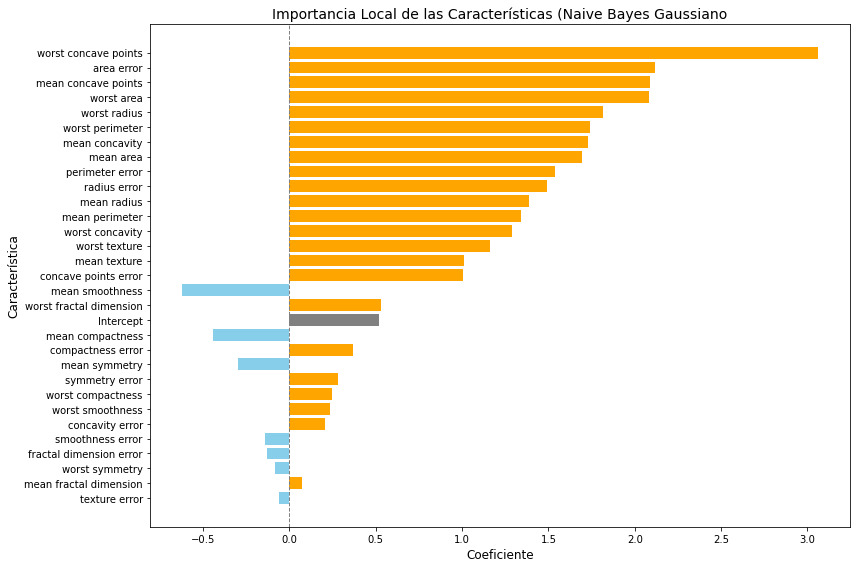

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

# (Asumiendo que tienes la función feature_weights_naive_bayes_local definida)

def plot_feature_importance_local_naive_bayes(x_predict, X, y, feature_names):
    """
    Calcula y grafica la importancia local de las características para una nueva muestra 
    utilizando un modelo Naive Bayes Gaussiano.

    Args:
        x_new_index: Índice de la nueva muestra en el conjunto de datos X.
        X: Array de NumPy con las características. (Ya en formato NumPy)
        y: Vector de etiquetas de clase.
        feature_names: Lista de nombres de las características.
    """

    intercept, weights = feature_weights_naive_bayes_local(x_predict, X, y)

    # Combinar el intercept y los pesos
    coefficients = np.concatenate(([intercept], weights))

    # Crear DataFrame para el gráfico
    df = pd.DataFrame({'Coeficiente': coefficients, 'Característica': feature_names})
    df = df.reindex(df['Coeficiente'].abs().sort_values(ascending=True).index)

    # Colores para las barras
    colors = ['gray' if feature == 'Intercept' else 'orange' if coef > 0 else 'skyblue' for coef, feature in zip(df['Coeficiente'], df['Característica'])]


    # Gráfico de barras horizontales
    plt.figure(figsize=(12, 8))
    plt.barh(df['Característica'], df['Coeficiente'], color=colors)

    # Línea vertical en cero
    plt.axvline(0, color='gray', linestyle='dashed', linewidth=1)

    # Títulos y etiquetas
    plt.title(f'Importancia Local de las Características (Naive Bayes Gaussiano', fontsize=14)
    plt.xlabel('Coeficiente', fontsize=12)
    plt.ylabel('Característica', fontsize=12)
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

# Cargar datos de Breast Cancer (Ya en formato NumPy)
breast_cancer = load_breast_cancer()
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names).values
y = breast_cancer.target

# Ejemplo de uso:
plot_feature_importance_local_naive_bayes(X[20], X, y, np.concatenate((["Intercept"], breast_cancer.feature_names))) 


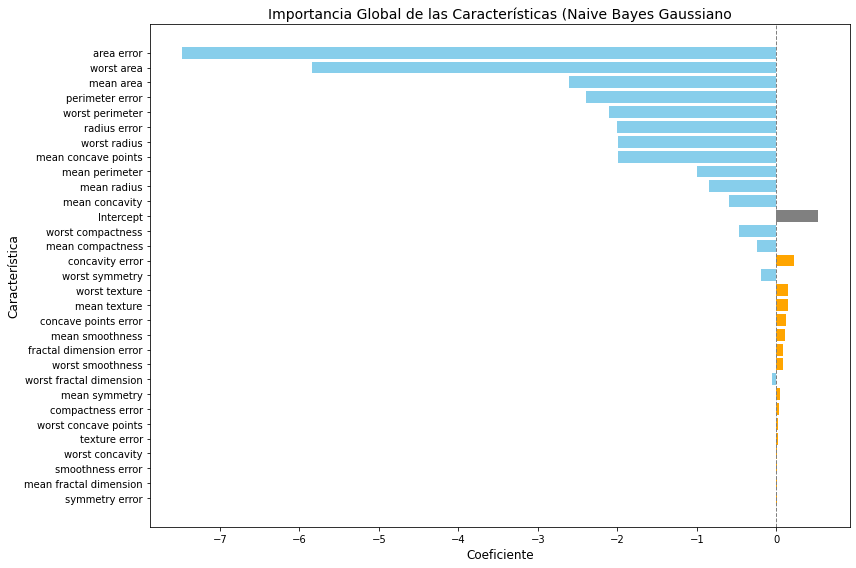

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

# (Asumiendo que tienes la función feature_weights_naive_bayes_local definida)

def plot_feature_importance_global_naive_bayes( X, y, feature_names):


    intercept, weights = feature_weights_naive_bayes_global( X, y)

    # Combinar el intercept y los pesos
    coefficients = np.concatenate(([intercept], weights))

    # Crear DataFrame para el gráfico
    df = pd.DataFrame({'Coeficiente': coefficients, 'Característica': feature_names})
    df = df.reindex(df['Coeficiente'].abs().sort_values(ascending=True).index)

    # Colores para las barras
    colors = ['gray' if feature == 'Intercept' else 'orange' if coef > 0 else 'skyblue' for coef, feature in zip(df['Coeficiente'], df['Característica'])]


    # Gráfico de barras horizontales
    plt.figure(figsize=(12, 8))
    plt.barh(df['Característica'], df['Coeficiente'], color=colors)

    # Línea vertical en cero
    plt.axvline(0, color='gray', linestyle='dashed', linewidth=1)

    # Títulos y etiquetas
    plt.title(f'Importancia Global de las Características (Naive Bayes Gaussiano', fontsize=14)
    plt.xlabel('Coeficiente', fontsize=12)
    plt.ylabel('Característica', fontsize=12)
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

# Cargar datos de Breast Cancer (Ya en formato NumPy)
breast_cancer = load_breast_cancer()
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names).values
y = breast_cancer.target

# Ejemplo de uso:
plot_feature_importance_global_naive_bayes( X, y, np.concatenate((["Intercept"], breast_cancer.feature_names))) 

In [19]:
import pandas as pd
from sklearn.datasets import load_breast_cancer

# Cargar el conjunto de datos
breast_cancer = load_breast_cancer()

# Crear un DataFrame con las características
df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)

# Agregar la columna objetivo al DataFrame
df['target'] = breast_cancer.target

# Mostrar las primeras filas del DataFrame
print(df.head())


   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

In [20]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split
import logging
from sklearn.impute import SimpleImputer  # Para imputar valores faltantes
import pandas as pd
from sklearn.metrics import accuracy_score


# ... (tus clases NaiveBayesExplanation y NaiveBayesClassifier)

# Configurar el registro para ver mensajes de depuración
logging.basicConfig(level=logging.INFO)

# Cargar el conjunto de datos Breast Cancer
breast_cancer = load_breast_cancer()
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = breast_cancer.target

feature_weights_naive_bayes_local(X.iloc[0].values,X.values, y)

(0.5211495071076268,
 array([-4.80046023e+00,  2.59133193e+00, -6.52112833e+00, -7.04533385e+00,
        -1.16948305e+00, -1.36820981e+01, -1.48684881e+01, -2.69345332e+01,
        -2.05038301e+00, -3.99042504e-01, -2.39040526e+01, -1.41720717e-01,
        -3.40129843e+01, -1.09352594e+02, -8.34298393e-02, -8.95012494e-01,
        -6.25443345e-01, -5.80402238e-01, -9.80597993e-02, -1.97625722e-01,
        -1.71288109e+01,  1.79707979e+00, -2.42399087e+01, -3.81419758e+01,
        -1.33200716e+00, -1.16852975e+01, -6.27989341e+00, -1.23909125e+01,
        -8.10896897e+00, -2.84205988e+00]))